<a href="https://colab.research.google.com/github/SunilkumarAdapa/Projects.-ASK/blob/main/RAG_Embeddingd_and_Google_T5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Retrieval-Augmented Generation with Hugging Face Embeddings and Google T5**

In [1]:
#pip
%%capture
#@title Setup Environment
# Install the latest Tensorflow version.
!pip install transformers
!pip install sentencepiece


**Import libraries**

In [30]:
import pandas as pd
import os
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers.optimization import  Adafactor
import time
import warnings
warnings.filterwarnings('ignore')
from nltk.translate.bleu_score import corpus_bleu

**Preprocess**

In [5]:
#Preprocess
import urllib.request
import zipfile
import glob
import os
import re
import xml.etree.ElementTree as ET
url = 'https://gitlab.com/shimorina/webnlg-dataset/-/archive/master/webnlg-dataset-master.zip?path=release_v3.0/en/train'
urllib.request.urlretrieve(url, 'web.zip')
with zipfile.ZipFile('web.zip', 'r') as zip_ref:
    zip_ref.extractall('web')
    files = glob.glob("/content/web/webnlg-dataset-master-release_v3.0-en-train/release_v3.0/en/train/**/*.xml", recursive=True)
triple_re=re.compile('(\d)triples')
data_dct={}
for file in files:
    tree = ET.parse(file)
    root = tree.getroot()
    triples_num=int(triple_re.findall(file)[0])
    for sub_root in root:
        for ss_root in sub_root:
            strutured_master=[]
            unstructured=[]
            for entry in ss_root:
                unstructured.append(entry.text)
                strutured=[triple.text for triple in entry]
                strutured_master.extend(strutured)
            unstructured=[i for i in unstructured if i.replace('\n','').strip()!='' ]
            strutured_master=strutured_master[-triples_num:]
            strutured_master_str=(' && ').join(strutured_master)
            data_dct[strutured_master_str]=unstructured
mdata_dct={"prefix":[], "input_text":[], "target_text":[]}
for st,unst in data_dct.items():
    for i in unst:
        mdata_dct['prefix'].append('webNLG')
        mdata_dct['input_text'].append(st)
        mdata_dct['target_text'].append(i)


df=pd.DataFrame(mdata_dct)
df.to_csv('webNLG2020_train.csv')

**Load Data**

In [7]:
#load the Data
train_df =pd.read_csv('/content/webNLG2020_train.csv',index_col=[0])

In [8]:
train_df =train_df.iloc[ :3500,:] #trim off a few data points and so that batch would not leave any remainder

In [9]:
train_df=train_df.sample(frac=1)

In [11]:
batch_size=8
num_of_batches=len(train_df)/batch_size
num_of_epochs=4
num_of_batches=int(num_of_batches)

In [14]:
#check for the GPU availability
if torch.cuda.is_available():
    dev = torch.device("cuda:0")
    print("Running on the GPU")
else:
    dev = torch.device("cpu")
    print("Running on the CPU")

Running on the CPU


**Loading the pretrained model and tokenizer**

In [16]:
#Loading the pretrained model and tokenizer
tokenizer = T5Tokenizer.from_pretrained('t5-base')
model = T5ForConditionalGeneration.from_pretrained('t5-base', return_dict=True)
#moving the model to device(GPU/CPU)
model.to(dev)

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [17]:
#initializing the Adafactor optimizer with parameter values suggest for t5
optimizer = Adafactor(
    model.parameters(),
    lr=1e-3,
    eps=(1e-30, 1e-3),
    clip_threshold=1.0,
    decay_rate=-0.8,
    beta1=None,
    weight_decay=0.0,
    relative_step=False,
    scale_parameter=False,
    warmup_init=False
)


In [18]:
from IPython.display import HTML, display

def progress(loss,value, max=100):
    return HTML(""" Batch loss :{loss}

            {value}

    """.format(loss=loss,value=value, max=max))

In [20]:
num_of_epochs=1#due it take more time i reduced the size of epochs

**#Training the model**

In [21]:
#Training the model
#Sets the module in training mode
model.train()

loss_per_10_steps=[]
for epoch in range(1,num_of_epochs+1):
  print('Running epoch: {}'.format(epoch))

  running_loss=0

  out = display(progress(1, num_of_batches+1), display_id=True)
  for i in range(num_of_batches):
    inputbatch=[]
    labelbatch=[]
    new_df=train_df[i*batch_size:i*batch_size+batch_size]
    for indx,row in new_df.iterrows():
      input = 'WebNLG: '+row['input_text']+''
      labels = row['target_text']+''
      inputbatch.append(input)
      labelbatch.append(labels)
    inputbatch=tokenizer.batch_encode_plus(inputbatch,padding=True,max_length=400,return_tensors='pt')["input_ids"]
    labelbatch=tokenizer.batch_encode_plus(labelbatch,padding=True,max_length=400,return_tensors="pt") ["input_ids"]
    inputbatch=inputbatch.to(dev)
    labelbatch=labelbatch.to(dev)

    # clear out the gradients of all Variables
    optimizer.zero_grad()

    # Forward propogation
    outputs = model(input_ids=inputbatch, labels=labelbatch)
    loss = outputs.loss
    loss_num=loss.item()
    logits = outputs.logits
    running_loss+=loss_num
    if i%10 ==0:
      loss_per_10_steps.append(loss_num)
    out.update(progress(loss_num,i, num_of_batches+1))

    # calculating the gradients
    loss.backward()

    #updating the params
    optimizer.step()

  running_loss=running_loss/int(num_of_batches)
  print('Epoch: {} , Running loss: {}'.format(epoch,running_loss))

Running epoch: 1


Epoch: 1 , Running loss: 0.3221476610997176


**plotting the loss over time**

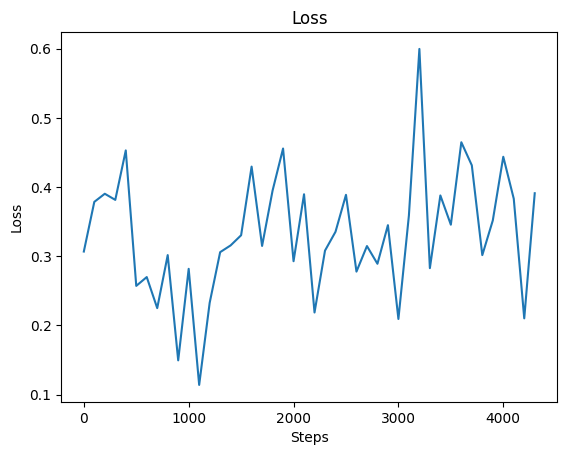

In [22]:
#plotting the loss over time
import matplotlib.pyplot as plt

steps = [i*100 for i in range(len(loss_per_10_steps))]

plt.plot(steps, loss_per_10_steps)
plt.title('Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

**Testing the model**

In [23]:
#testing the model
model.eval()
input_ids = tokenizer.encode("WebNLG: sidharth | hometown | Delhi && sidharth | play |  football ", return_tensors="pt")  # Batch size 1
input_ids=input_ids.to(dev)
outputs = model.generate(input_ids)
tokenizer.decode(outputs[0])

'<pad> The Sidharth plays for Delhi & Sidharth.</s>'

In [34]:
# Define reference sentences
references = ["Sidharth lives in Delhi and plays football.", "Sidharth's hometown is Delhi and he plays football."]

# Split the generated text into sentences if needed
generated_sentences = generated_text.split(".")

# Ensure that the number of hypotheses matches the number of reference sentences
num_references = len(references)
num_hypotheses = len(generated_sentences)

# If the number of hypotheses is greater than the number of references, trim excess hypotheses
if num_hypotheses > num_references:
    generated_sentences = generated_sentences[:num_references]
# If the number of references is greater than the number of hypotheses, pad references with empty strings
elif num_references > num_hypotheses:
    references = references[:num_hypotheses]

# Calculate BLEU score
bleu_score = corpus_bleu([[reference.split()] for reference in references], [generated.split() for generated in generated_sentences])
print("BLEU Score:", bleu_score)


BLEU Score: 4.5465250654993304e-232


In [27]:
torch.save(model.state_dict(),'pytoch_model.bin')